# Fondo de Población de las Naciones Unidas - Modelo Analítico

In [127]:
!pip install unidecode

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode
import unicodedata
import nltk

#PLN
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Material requerido para preprocesamiento de PLN
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

#Preparación datos para el Modelo
from sklearn.model_selection import train_test_split

#Construcción del Modelo
#Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
#SVM
from sklearn.svm import SVC
#Random Forest
from sklearn.ensemble import RandomForestClassifier
# Métricas de evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 0. Carga y Entendimiento de Datos

In [129]:
df_unfpa = pd.read_excel('./ODScat_345.xlsx',sheet_name='Datos')

In [130]:
df_unfpa.shape

(4049, 2)

In [131]:
df_unfpa.dtypes

,0
Textos_espanol,object
sdg,int64


In [132]:
df_unfpa.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [133]:
df_unfpa['Textos_espanol'].describe()

,Textos_espanol
count,4049
unique,4049
top,"Por ejemplo, el nÃºmero de consultas externas ..."
freq,1


In [134]:
from scipy import stats as st

textos = df_unfpa.copy()
textos['Conteo'] = [len(x) for x in textos['Textos_espanol']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos

,Textos_espanol,sdg,Conteo,Max,Min
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,944,18,1
1,"En 2007, el gobierno central financió directam...",3,476,14,1
2,"Claramente, hay muchos otros factores en juego...",3,1207,15,1
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,17,1
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,13,1
...,...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,822,16,1
4045,La participación de las mujeres en roles de li...,5,514,16,1
4046,"Según el WEF, según las tendencias de 2016, po...",5,445,17,1
4047,"Sirve como recurso y foro para las agencias, c...",5,1017,15,1


## 1. Fase 1, Preparación de Datos

### 1.1. Análisis de calidad

Se realizan revisiones para entender el nivel de completitud, unicidad y validez de los datos suministrados por el UNFPA. Tras la revisión no se encuentran problemas que deban ser intervenidos en esta primera revisión.

#### 1.1.1. Completitud

Se realiza un conteo de los valores nulos de las columnas que contienen los datos y se calcula su porcentaje. Con los resultados se evidencia completitud en la información suministrada por el UNFPA por lo que no son requeridas mayores acciones.

In [135]:
# Recuento de valores nulos por columna
null_counts = df_unfpa.isnull().sum()

# Porcentaje de valores nulos por columna
null_percentage = df_unfpa.isnull().mean() * 100

null_counts
null_percentage

,0
Textos_espanol,0.0
sdg,0.0


#### 1.1.2. Unicidad

Se lleva a cabo el conteo de registros duplicados en el dataframe. No se encuentran elementos duplicados.

In [136]:
# Verificar registros duplicados
duplicate_rows = df_unfpa[df_unfpa.duplicated()]

# Recuento de registros duplicados
duplicate_count = duplicate_rows.shape[0]

print(f"Número de registros duplicados: {duplicate_count}")


Número de registros duplicados: 0


#### 1.1.3. Validez

Para analizar la validez de los datos se comprueba que en la columna numérica "sdg", los registros estén dentro del límite. No se encuentran registros inválidos.

In [137]:
# Ejemplo de chequeo de validez en una columna numérica
valid_range = (df_unfpa['sdg'] >= 3) & (df_unfpa['sdg'] <= 5)
invalid_values = df_unfpa[~valid_range]

print(f"Número de valores no válidos en 'columna_numerica': {invalid_values.shape[0]}")


Número de valores no válidos en 'columna_numerica': 0


### 1.2. Procesamiento de Lenguaje Natural (PLN)

Se realiza el preprocesamiento necesario para convertir los textos en un formato de tokens procesable por el modelo. Se realizan las siguientes acciones:

**Limpieza del Texto:** Eliminación de caracteres especiales, puntuación y números

**Normalización:** Conversión a minúsculas y eliminación de stopwords (palabras comunes que no aportan significado)

**Tokenización:** División del texto en palabras individuales o "tokens"

**Lematización:** Reducción de las palabras a su forma base

**Manejo Unicode:** Decisiones sobre problemas/conflictos debido a la codificación de los acentos y caracteres especiales en la codificación.

In [138]:
df_unfpa = pd.read_excel('./ODScat_345.xlsx',sheet_name='Datos')

stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def preprocess_text(text):

    text = text.lower()

    text = remove_accents(text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii



    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)

    words = word_tokenize(text)

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

df_unfpa['Textos_preprocesados'] = df_unfpa['Textos_espanol'].apply(preprocess_text)
print(df_unfpa[['Textos_espanol', 'Textos_preprocesados']].head())

                                      Textos_espanol  \
0  Por ejemplo, el nÃºmero de consultas externas ...   
1  En 2007, el gobierno central financió directam...   
2  Claramente, hay muchos otros factores en juego...   
3  Por ejemplo, el estado australiano de Victoria...   
4  El consumo anual de alcohol se estima en 15,7 ...   

                                Textos_preprocesados  
0  ejemplo naomero consultas externas especialist...  
1  gobierno central financio directamente solo ga...  
2  claramente factores juego particular variedad ...  
3  ejemplo australiano victoria creo agencia prom...  
4  consumo anual alcohol estima litros ano hombre...  


Para que el modelo pueda trabajar con el texto, se convierten las palabras en vectores numéricos. Se implmeneta la técnica TF-IDF (Term Frequency-Inverse Document Frequency).
Este algoritmo "está diseñado para resaltar palabras que son frecuentes dentro de un documento específico y relativamente raras en todo el cuerpo, lo que ayuda a identificar términos que son importantes para un documento en particular"([IBM, ¿Qué son las incrustaciones de palabras?](https://www.ibm.com/mx-es/topics/word-embeddings)).
Se limita la cantidad de características más comunes a 5000 con base en el tamaño de los registros buscando que el límite esté por encima de la cantidad de registros en escala de miles.

In [139]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limitar a 5000 características más comunes
X = vectorizer.fit_transform(df_unfpa['Textos_preprocesados'])

X.shape

(4049, 5000)

Una vez aplicada la estrategia TF-IDF, se genera una gráfica para visualizar las palabras más frecuentes en el conjunto de datos.

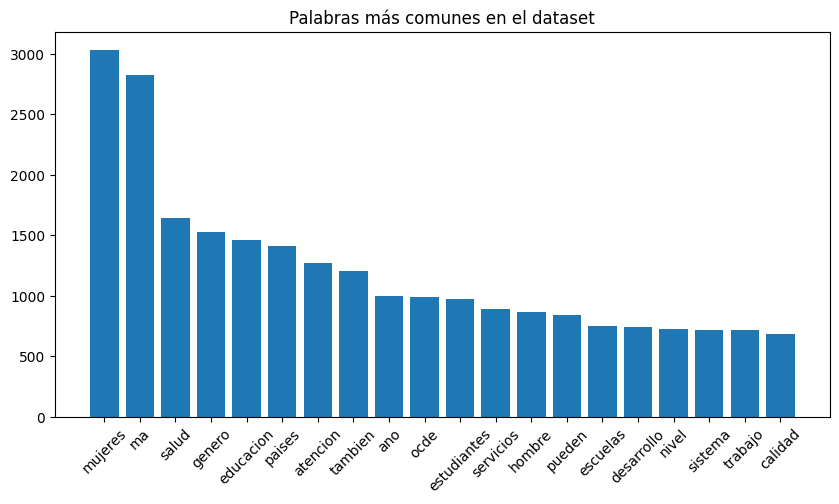

In [140]:
# Unir todos los textos para análisis
all_words = ' '.join(df_unfpa['Textos_preprocesados']).split()

# Contar las palabras más comunes
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

# Visualización
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.title('Palabras más comunes en el dataset')
plt.xticks(rotation=45)
plt.show()

Una vez realizadas las modificaciones necesarias en los datos, se establecen los conjuntos de entrenamiento y de prueba.

In [154]:
# Definir las características (X) y las etiquetas (y)
X = vectorizer.transform(df_unfpa['Textos_preprocesados'])
y = df_unfpa['sdg']

df_unfpa.to_excel('./ODScat_345_preprocesado.xlsx', index=False)
files.download('./ODScat_345_preprocesado.xlsx')

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tamaño del conjunto de entrenamiento: (3239, 5000)
Tamaño del conjunto de prueba: (810, 5000)


## 2. Fase 2, Modelo

Se realiza la creación, entrenamiento, comprobación y cálculo de estadísticos para los modelos Naive Bayes, SVM y Random Forest. Posteriormente, con base en los estadísticos, se generan las métricas a partir de una comparativa entre el comportamiento de cada modelo para tomar decisiones acerca de la mejor elección para el UNFPA.

### 2.1. Naive Bayes

EL primer algoritmo que se implementará para el modelo es Naive Bayes. Este algoritmo de aprendizaje automático supervisado se utiliza para tareas de clasificación, como la clasificación de texto. Utiliza principios de probabilidad para realizar tareas de clasificación. ([IBM, ¿Qué son los clasificadores Naïve Bayes?](https://www.ibm.com/mx-es/topics/naive-bayes#:~:text=El%20clasificador%20Na%C3%AFve%20Bayes%20es,para%20realizar%20tareas%20de%20clasificaci%C3%B3n.))

In [142]:
# Crear el modelo
nb_model = MultinomialNB()

# Entrenar el modelo
nb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_nb = nb_model.predict(X_test)

# Evaluar el modelo
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print(f"Naive Bayes - Accuracy: {accuracy_nb}")
print(f"Classification Report:\n{report_nb}")

Naive Bayes - Accuracy: 0.9728395061728395
Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.97      0.98       250
           4       0.96      0.98      0.97       268
           5       0.96      0.97      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



In [143]:
y_pred = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred, average='weighted')
nb_recall = recall_score(y_test, y_pred, average='weighted')
nb_f1 = f1_score(y_test, y_pred, average='weighted')

nb_conf_matrix = confusion_matrix(y_test, y_pred)

nb_class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1 Score: {nb_f1}")
print(f"Confusion Matrix:\n{nb_conf_matrix}")
print(f"Classification Report:\n{nb_class_report}")


Accuracy: 0.9728395061728395
Precision: 0.973229266474545
Recall: 0.9728395061728395
F1 Score: 0.9729106789235
Confusion Matrix:
[[242   2   6]
 [  0 263   5]
 [  0   9 283]]
Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.97      0.98       250
           4       0.96      0.98      0.97       268
           5       0.96      0.97      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



### 2.2. SVM

El segundo algoritmo que se implementa para el modelo es SVM (Support Vector Machine).
"SVM funciona correlacionando datos a un espacio de características de grandes dimensiones de forma que los puntos de datos se puedan categorizar, incluso si los datos no se puedan separar linealmente de otro modo. Se detecta un separador entre las categorías y los datos se transforman de forma que el separador se puede extraer como un hiperplano. Tras ello, las características de los nuevos datos se pueden utilizar para predecir el grupo al que pertenece el nuevo registro." ([IBM, Funcionamiento de SVM, 2024](https://www.ibm.com/docs/es/spss-modeler/saas?topic=models-how-svm-works))

In [144]:
# Crear el modelo
svm_model = SVC(kernel='linear')

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print(f"SVM - Accuracy: {accuracy_svm}")
print(f"Classification Report:\n{report_svm}")

SVM - Accuracy: 0.9827160493827161
Classification Report:
              precision    recall  f1-score   support

           3       0.98      0.99      0.99       250
           4       0.97      0.98      0.98       268
           5       0.99      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



In [145]:
y_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='weighted')
svm_recall = recall_score(y_test, y_pred, average='weighted')
svm_f1 = f1_score(y_test, y_pred, average='weighted')

svm_conf_matrix = confusion_matrix(y_test, y_pred)

svm_class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1 Score: {svm_f1}")
print(f"Confusion Matrix:\n{svm_conf_matrix}")
print(f"Classification Report:\n{svm_class_report}")

Accuracy: 0.9827160493827161
Precision: 0.9827678163171991
Recall: 0.9827160493827161
F1 Score: 0.982715770697936
Confusion Matrix:
[[248   2   0]
 [  2 263   3]
 [  2   5 285]]
Classification Report:
              precision    recall  f1-score   support

           3       0.98      0.99      0.99       250
           4       0.97      0.98      0.98       268
           5       0.99      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



### 2.3. Random Forest

El tercer algoritmo es Random Forest. Este algoritmo "Combina los resultados de múltiples árboles de decisión para llegar a un resultado único. Su facilidad de uso y flexibilidad han impulsado su adopción, ya que maneja tanto problemas de clasificación como de regresión."([IBM, What is random forest?](https://www.ibm.com/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,Decision%20trees))

In [146]:
# Crear el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}")
print(f"Classification Report:\n{report_rf}")

Random Forest - Accuracy: 0.9703703703703703
Classification Report:
              precision    recall  f1-score   support

           3       0.97      0.98      0.98       250
           4       0.96      0.97      0.97       268
           5       0.98      0.96      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



In [147]:
y_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')
rf_f1 = f1_score(y_test, y_pred, average='weighted')

rf_conf_matrix = confusion_matrix(y_test, y_pred)

rf_class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Confusion Matrix:\n{rf_conf_matrix}")
print(f"Classification Report:\n{rf_class_report}")

Accuracy: 0.9703703703703703
Precision: 0.9704832668340293
Recall: 0.9703703703703703
F1 Score: 0.9703668462266671
Confusion Matrix:
[[245   2   3]
 [  4 261   3]
 [  3   9 280]]
Classification Report:
              precision    recall  f1-score   support

           3       0.97      0.98      0.98       250
           4       0.96      0.97      0.97       268
           5       0.98      0.96      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



## Resultados

### 3.1. Comparación Métricas

In [148]:
print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

print("SVM Report:")
print(classification_report(y_test, y_pred_svm))

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Naive Bayes Report:
              precision    recall  f1-score   support

           3       1.00      0.97      0.98       250
           4       0.96      0.98      0.97       268
           5       0.96      0.97      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810

SVM Report:
              precision    recall  f1-score   support

           3       0.98      0.99      0.99       250
           4       0.97      0.98      0.98       268
           5       0.99      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810

Random Forest Report:
              precision    recall  f1-score   support

           3       0.97      0.98      0.98       250
           4       0.96      0.97      0.97       268
           5       0.

In [149]:
metrics = {
    'Naive Bayes': {
        'accuracy': nb_accuracy,
        'precision': nb_precision,
        'recall': nb_recall,
        'f1': nb_f1
    },
    'SVM': {
        'accuracy': svm_accuracy,
        'precision': svm_precision,
        'recall': svm_recall,
        'f1': svm_f1
    },
    'Random Forest': {
        'accuracy': rf_accuracy,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1': rf_f1
    }
}

max_values = {
    'accuracy': ('', float('-inf')),
    'precision': ('', float('-inf')),
    'recall': ('', float('-inf')),
    'f1': ('', float('-inf'))
}

for model, values in metrics.items():
    for metric in max_values:
        if values[metric] > max_values[metric][1]:
            max_values[metric] = (model, values[metric])

for metric in max_values:
    model, value = max_values[metric]
    print(f"Max {metric.capitalize()} value: {value} (Model: {model})")


Max Accuracy value: 0.9827160493827161 (Model: SVM)
Max Precision value: 0.9827678163171991 (Model: SVM)
Max Recall value: 0.9827160493827161 (Model: SVM)
Max F1 value: 0.982715770697936 (Model: SVM)


### 3.2. Resumen de Resultados
**Máxima precisión (accuracy):** 0.9827, alcanzada por el modelo SVM.
**Máxima precisión (precision):** 0.9828, alcanzada por el modelo SVM.
**Máximo recall:** 0.9827, alcanzado por el modelo SVM.
**Máximo F1-score:** 0.9827, alcanzado por el modelo SVM.

#### Evaluación Individual de Modelos
##### Naive Bayes:

**Precisión general:** 0.97
**Precision (macro avg):** 0.98
**Recall (macro avg):** 0.97
**F1-score (macro avg):** 0.97

Este modelo muestra un buen rendimiento general. Sin embargo, es ligeramente inferior comparado al de SVM, sobre todo al comparar el F1-score.

##### Support Vector Machine (SVM):

**Precisión general:** 0.98
**Precision (macro avg):** 0.98
**Recall (macro avg):** 0.98
**F1-score (macro avg):** 0.98

SVM es el modelo que mejor desempeño presenta en todas las métricas.

##### Random Forest:

**Precisión general:** 0.97
**Precision (macro avg):** 0.97
**Recall (macro avg):** 0.97
**F1-score (macro avg):** 0.97

Random Forest también muestra un buen rendimiento, pero es inferior al modelo SVM.

##### Conclusión

El modelo SVM es el más adecuado para la clasificación de opiniones en relación con los ODS, con base en las métricas calculadas. Este modelo ofrece la mejor precisión, recall y F1-score, lo que lo convierte en la opción que se tomará para entregar el proyecto.

## Exportar el modelo

In [150]:
import joblib
from google.colab import files

joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

## Aplicación del modelo

Simulando la puesta en operación del modelo, se realizará el proceso de carga, limpieza, preprocesamiento y predicción del modelo sobre el conjunto de datos de prueba suministrados. Se crea una columna para almacenar la etiqueta con tipo de dato int64 respectiva a los ODS.

In [151]:
df_pruebas = pd.read_excel('./TestODScat_345.xlsx')
df_pruebas.head()

,Textos_espanol,sdg
0,Han examinado la contribuciÃ³n de las univers...,NaN
1,"En la última década, y en particular desde 201...",NaN
2,¿En qué países los estudiantes de alto rendimi...,NaN
3,A raíz de su preocupación por el hecho de que ...,NaN
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",NaN


In [152]:
df_pruebas['Textos_preprocesados'] = df_pruebas['Textos_espanol'].apply(preprocess_text)
X_pruebas = vectorizer.transform(df_pruebas['Textos_preprocesados'])

In [153]:
svm_model = joblib.load('./svm_model.pkl')
predicciones = svm_model.predict(X_pruebas)

df_pruebas['sdg'] = predicciones
df_pruebas[['Textos_espanol', 'sdg']].to_excel('./PruebasODS_Predicciones.xlsx', index=False)
files.download('./PruebasODS_Predicciones.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>